In [37]:
'''Clean up trip data files into unified dataset

'''

# %% Initialize
# import glob
import pandas as pd
import numpy as np
# from scipy import stats

import matplotlib.pyplot as plt
# import matplotlib.ticker as mtick
# import matplotlib.dates as mdates

import geocoder
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM

path = 'data/'


In [38]:
# Read data
data = pd.read_pickle(f'{path}all_data.pkl')

In [39]:
# Load Published Station Lists
path_stations = f'{path}stations/'

stations1 = pd.read_csv(f'{path_stations}Hubway_Stations_2011_2016.csv')
stations2 = pd.read_csv(f'{path_stations}previous_Hubway_Stations_as_of_July_2017.csv')
stations3 = pd.read_csv(f'{path_stations}Hubway_Stations_as_of_July_2017.csv')
stations4 = pd.read_csv(f'{path_stations}current_bluebikes_stations.csv', skiprows=1)

# print(stations1.columns.values)
# print(stations2.columns.values)
# print(stations3.columns.values)
# print(stations4.columns.values)

stations1.rename(columns={'Station': 'station_name',
                          'Station ID': 'station_id',
                          'Latitude': 'latitude',
                          'Longitude': 'longitude',
                          'Municipality': 'city',
                          '# of Docks': 'dock_count',},
                          inplace=True)
stations2.rename(columns={'Station ID': 'station_id',
                          'Station': 'station_name',
                          'Latitude': 'latitude',
                          'Longitude': 'longitude',
                          'Municipality': 'city',
                          'publiclyExposed': 'public',
                          '# of Docks': 'dock_count',},
                          inplace=True)
stations3.rename(columns={'Number': 'station_id',
                          'Name': 'station_name',
                          'Latitude': 'latitude',
                          'Longitude': 'longitude',
                          'District': 'city',
                          'Public': 'public',
                          'Total docks': 'dock_count'},
                          inplace=True)
stations4.rename(columns={'Number': 'station_id',
                          'Name': 'station_name',
                          'Latitude': 'latitude',
                          'Longitude': 'longitude',
                          'District': 'city',
                          'Public': 'public',
                          'Total docks': 'dock_count',
                          'Deployment Year': 'deployment_year'},
                          inplace=True)

stations = pd.concat([stations1, stations2, stations3, stations4], ignore_index=True)

stations.city.unique()

stations_data = set(data['start_station_id'])

stations_missing = list(stations_data - set(stations['station_id']))

In [40]:
# (Reverse-)geocoded station list function
def station_list(df):
    # https://datascientyst.com/reverse-geocoding-latitude-longitude-city-country-python-pandas/
    stationListStart = df[['start_station_id', 'start_station_name','start_station_latitude', 'start_station_longitude']].sort_values('start_station_id').drop_duplicates('start_station_id', keep='last').reset_index()
    stationListEnd = df[['end_station_id', 'end_station_name','end_station_latitude', 'end_station_longitude']].sort_values('end_station_id').drop_duplicates('end_station_id', keep='last').reset_index()

    colNames = ['index', 'station_id', 'station_name','latitude', 'longitude']
    stationListStart.columns = colNames
    stationListEnd.columns = colNames

    # Create single list
    stationList = pd.concat([stationListStart, stationListEnd], ignore_index=True)
    stationList = stationList.sort_values('station_id').drop_duplicates('station_id', keep='last').reset_index()
    stationList = stationList.drop(['index', 'level_0'], axis=1)

    # Clean up list of invalid coordinates
    stationList['latitude'].replace(0, np.nan, inplace=True)
    stationList['longitude'].replace(0, np.nan, inplace=True)
    stationList['latitude'].replace('0.0', np.nan, inplace=True)
    stationList['longitude'].replace('0.0', np.nan, inplace=True)
    stationList.dropna(subset=['latitude', 'longitude'], inplace=True)

    print(stationList[['station_id', 'latitude', 'longitude']].head())
    print(len(stationList))

    def geo_rev(x):
        g = geocoder.osm([x.latitude, x.longitude], method='reverse').json
        if g:
            return g
        else:
            return 'no data'

    stationList['json'] = stationList[['latitude', 'longitude']].apply(geo_rev, axis=1)


    stationList['city'] = ''
    for index, row in stationList.iterrows():
        if 'city' in row['json']:
            stationList.at[index,'city'] = row['json']['city']
        elif 'town' in row['json']:
            stationList.at[index,'city'] = row['json']['town']


    # Make all cities to remove easy later
    ignoreCities = ['Montréal']
    stationList['city'].replace(ignoreCities, np.nan, inplace=True)

    toNumeric = ['longitude', 'latitude']
    stationList[toNumeric] = stationList[toNumeric].apply(pd.to_numeric)

    stationList.to_pickle('stationlist.pkl')

    return stationList


In [41]:
# Run reverse-geocoding function
# stationList = station_list(data)

# Load saved reverse geocoded statio list
stationList = pd.read_pickle('stationlist.pkl')

stationList['city'].unique()

array(['Boston', 'Somerville', 'Brookline', 'Cambridge', 'Quincy',
       'Everett', 'Watertown', 'Arlington', 'Newton', 'Revere', 'Chelsea',
       'Salem', 'Medford', 'Malden'], dtype=object)

In [42]:
# cityList = ['Boston', 'Brookline', 'Cambridge', 'Somerville', 'Everett',
#             'Watertown', 'Chelsea', 'Newton', 'Salem', 'Arlington', 'Medford',
#             'Malden', 'Revere']

cityList = stationList['city'].unique()

data['start_city'] = np.nan
data['end_city'] = np.nan

for index, row in stationList.iterrows():
    data.loc[data['start_station_id'] == row['station_id'], 'start_city'] = row['city']
    data.loc[data['end_station_id'] == row['station_id'], 'end_city'] = row['city']

data.dropna(subset=['start_city', 'end_city'], inplace=True)

data.to_pickle(f'{path}all_data_cities.pkl')

print(data['start_city'].unique())
print(data['end_city'].unique())


['Boston' 'Cambridge' 'Somerville' 'Brookline' 'Quincy' 'Everett'
 'Watertown' 'Arlington' 'Newton' 'Revere' 'Chelsea' 'Salem' 'Medford'
 'Malden']
['Boston' 'Cambridge' 'Somerville' 'Brookline' 'Quincy' 'Everett'
 'Watertown' 'Arlington' 'Newton' 'Revere' 'Chelsea' 'Salem' 'Medford'
 'Malden']


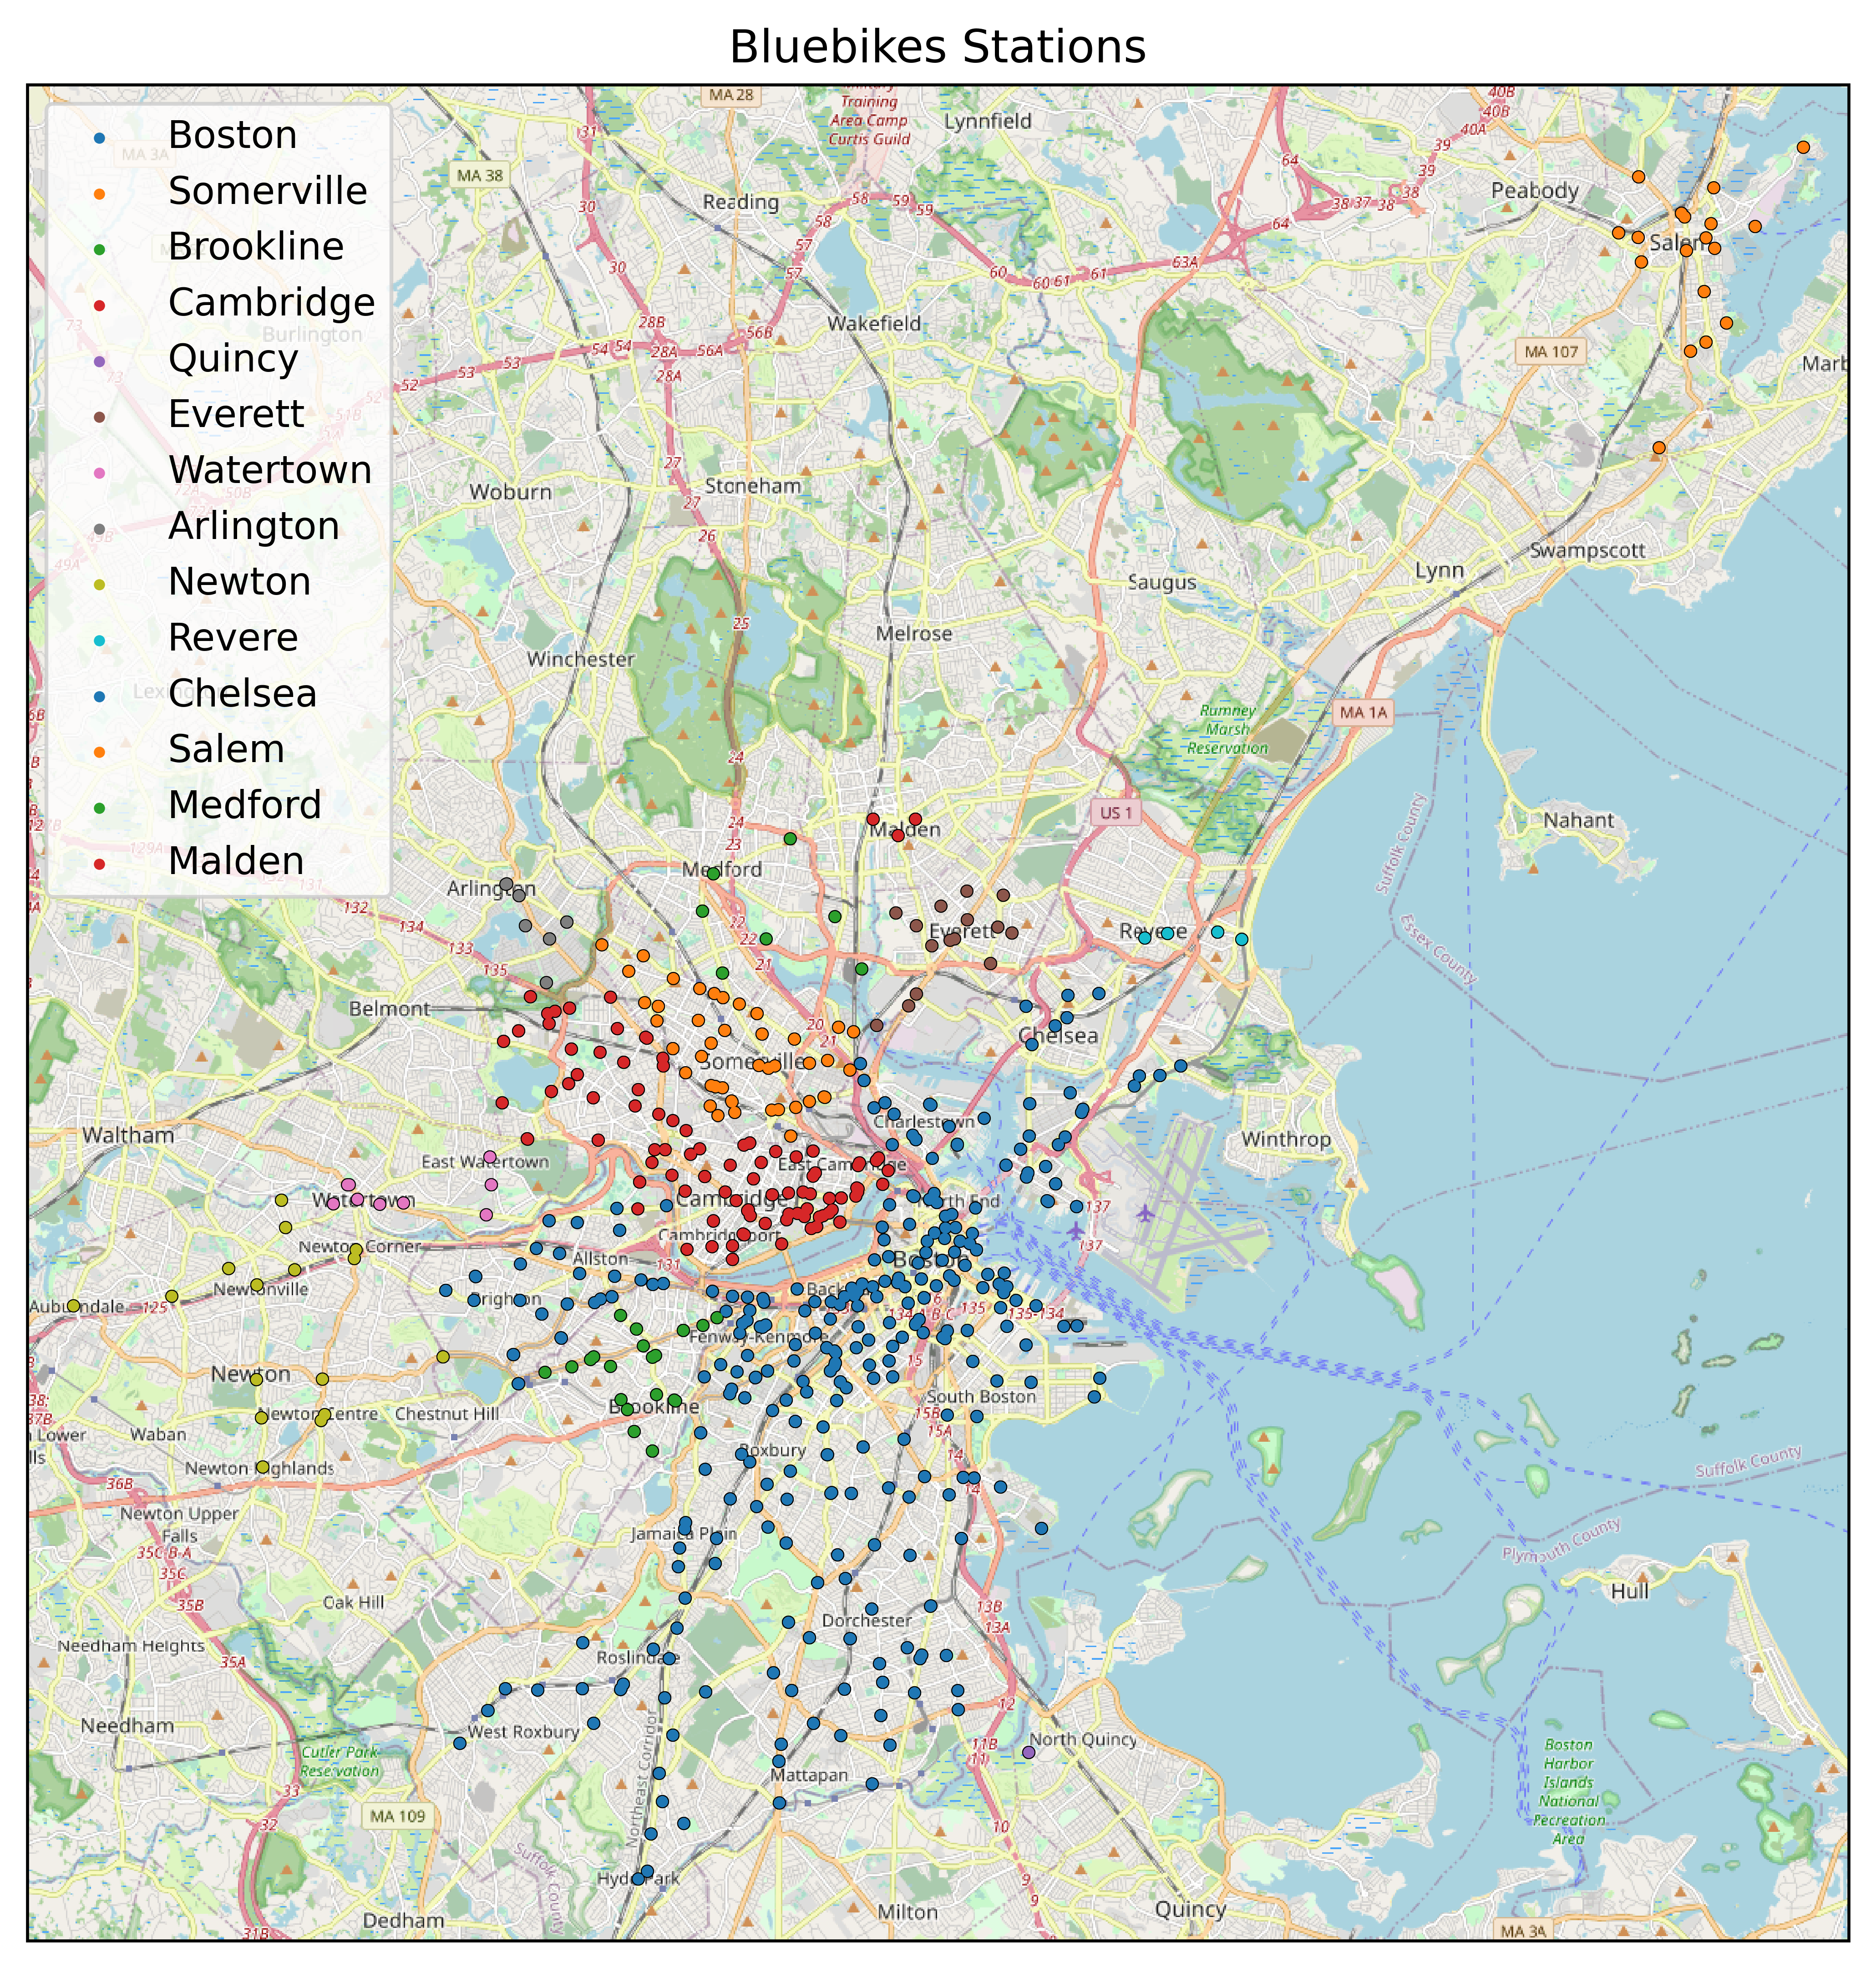

In [43]:
# Plots! - Stations
data = pd.read_pickle(f'{path}all_data_cities.pkl')
stationList = pd.read_pickle('stationlist.pkl')
cityList = stationList['city'].unique()

imagery = OSM()

buffer = 0.01

fig = plt.figure(figsize=(15, 9), dpi=600)
ax = plt.axes(projection=imagery.crs)
ax.set_extent((stationList['longitude'].min() - buffer, stationList['longitude'].max() + buffer, 
               stationList['latitude'].min() - buffer, stationList['latitude'].max() + buffer))  # Left, Right, Bottom, Top

# Add the imagery to the map.
ax.add_image(imagery, 12)  # Number is scale, larger gives finer detail

plt.scatter(stationList['longitude'], stationList['latitude'], transform=ccrs.PlateCarree(),
                        marker='.', s=25, color='black')

for city in cityList:
    long = stationList[stationList['city'] == city]['longitude']
    lat = stationList[stationList['city'] == city]['latitude']
    plt.scatter(long, lat, transform=ccrs.PlateCarree(),
                        marker='.', s=15, label=city)
    


plt.title('Bluebikes Stations')
plt.legend()
plt.show()

In [44]:
stationList.groupby(['city'])['station_id'].count().sort_values(ascending=False)

city
Boston        483
Cambridge     146
Somerville     68
Salem          33
Newton         30
Everett        26
Brookline      25
Watertown      14
Arlington      12
Chelsea        12
Medford        11
Revere          8
Malden          6
Quincy          2
Name: station_id, dtype: int64